# Load Libraries

In [6]:
# Uncomment to install PyWavelets and dtcwt
# !pip3 install PyWavelets
# !pip3 install dtcwt

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cv2
from PIL import Image
import os

# For semantic segmentation
import torch
import torchvision
from torchvision import transforms
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights

from skimage import io, color, img_as_float
from scipy.ndimage import gaussian_filter

from skimage.morphology import opening, closing, disk
from skimage import io, color, img_as_float, morphology
from scipy.ndimage import gaussian_filter
from scipy import ndimage as ndi

import pywt
import dtcwt
import csv
import pickle

print(np.__version__)

1.26.4


# Image Read

In [8]:
# read image of any format - png, bmp, jpg and return the rgb image as numpy array
# normalize the image to [0, 1] range
def read_img(image_path):
    img = Image.open(image_path)
    img = np.array(img)
    img = img / 255.0
    return img

# Segmentation - KMeans and Semantic

In [9]:
def kmeans(img, n_clusters, display=False):
    data = img.reshape((-1, 1))
    H, W = img.shape

    kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
    clusters = kmeans.fit_predict(data)
    clusters = clusters.reshape((H, W))

    if display:
        plt.imshow(clusters, cmap="Spectral")
        plt.title(f"Input Image Segmentation, n_clusters: {n_clusters}")
        plt.axis('off')
        plt.show()

    return clusters

In [10]:
def simple_segmentation(image, n_clusters=5, feature_space='rgb', smoothing_sigma=1,display=False):
    """
    Perform simple image segmentation using K-means clustering.

    Parameters:
    - image: Input image as a NumPy array.
    - n_clusters: The desired number of clusters (segments).
    - feature_space: The color space to use ('rgb' or 'lab').

    Returns:
    - labels: A 2D array of the same height and width as the image, containing the segment labels.
    """
    # Convert image to float representation
    image = img_as_float(image)
    h, w, c = image.shape

    # Apply image smoothing to reduce noise
    smoothed_image = gaussian_filter(image, sigma=(smoothing_sigma, smoothing_sigma, 0))

    # Choose feature space
    if feature_space == 'lab':
        # Convert to Lab color space for better perceptual similarity
        image_feats = color.rgb2lab(smoothed_image)
    else:
        # Use RGB color space
        image_feats = smoothed_image

    # Reshape the image to a 2D array of pixels and color features
    X = image_feats.reshape((-1, c))

    # Perform K-means clustering
    print("Performing K-means clustering...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_

    # Reshape labels back to image dimensions
    labels = labels.reshape((h, w))

    # Apply improved morphological operations to clean up small regions
    selem = morphology.disk(5)
    labels_cleaned = np.zeros_like(labels)
    min_size = 500  # Adjust this value based on image size

    for i in range(n_clusters):
        mask = (labels == i).astype(np.bool_)
        mask_filled = ndi.binary_fill_holes(mask)
        mask_cleaned = morphology.remove_small_objects(mask_filled, min_size=min_size)
        mask_smooth = morphology.closing(mask_cleaned, selem)
        mask_smooth = morphology.opening(mask_smooth, selem)
        labels_cleaned[mask_smooth] = i

    if display:
        plt.imshow(labels_cleaned, cmap='tab20')
        plt.axis('off')
        plt.title('Segmentation Result')
        plt.show()

    return labels_cleaned


# Band Processing

In [11]:
# Performs Log Normalization and z-tranforms and clips data [-1, 2] range
def normalize_coeffs(bands):
    reals = []
    imags = []
    for band in range(bands.shape[-1]):
        real_coeffs = bands[:, :, band].real
        imag_coeffs = bands[:, :, band].imag

        # Normalize
        # Log (1+x) transform
        eps = 1e-8
        real_coeffs = np.log10((real_coeffs) + abs(real_coeffs.min()) + eps)
        imag_coeffs = np.log10((imag_coeffs) + abs(imag_coeffs.min()) + eps)

        # Z-Scaling
        real_coeffs = (real_coeffs - real_coeffs.mean()) / (real_coeffs.std() + 1e-8)
        imag_coeffs = (imag_coeffs - imag_coeffs.mean()) / (imag_coeffs.std() + 1e-8)

        reals.append(real_coeffs)
        imags.append(imag_coeffs)

    return np.asarray(reals), np.asarray(imags)

In [12]:
def display_wavelet_coeffs(reals, imags, display=False, savepath=""):
    # Clip the data to [-1, 2] range
    reals = np.clip(reals, -1, 2)
    imags = np.clip(imags, -1, 2)
    if 1:
        plt.figure(figsize=(12, 4))
        for i, data in enumerate(zip(reals, imags)):
            real, imag = data

            plt.subplot(2, 6, i + 1)
            plt.imshow(real, cmap="Spectral")
            plt.title(f"Real, Band{i+1}")
            plt.axis('off')

            plt.subplot(2, 6, i + 7)
            plt.imshow(imag, cmap="Spectral")
            plt.title(f"Imag, Band{i+1}")
            plt.axis('off')

        plt.suptitle("Level 1, Real and Imaginary Bands 1-6")

        if savepath != "":
            plt.savefig(f"{savepath}_bands.png")
        
        if display:
            plt.show()
        else:
            plt.close()

In [13]:
def get_patch_mean_variance(band, patch_size):
    H, W = band.shape
    patch_means = []
    for h in range(0, H, patch_size):
        for w in range(0, W, patch_size):
            patch = band[h:h+patch_size, w:w+patch_size]
            patch_means.append(np.mean(patch))

    var = np.var(patch_means)
    return var

In [14]:
def get_band_variance(mask, reals, imags, patch_size):
    real_var = []
    imag_var = []
    for real, imag in zip(reals, imags):
        # Real first
        band = mask * real
        real_var.append(get_patch_mean_variance(band, patch_size))
        
        # Imag
        band = mask * imag
        imag_var.append(get_patch_mean_variance(band, patch_size))

    return np.asarray(real_var), np.asarray(imag_var)

In [15]:
def compute_threshold_dynamic(mask, real_coeffs, imag_coeffs, patch_size):
    var_reals, var_imag = get_band_variance(mask, real_coeffs, imag_coeffs, patch_size)
    var = np.concatenate((var_imag, var_reals))
    var = np.percentile(var, 95)
    return var

# Wavelets

In [16]:
# Return the coeffs of the DT-CWT transform
def wavelet_dtcwt(img):
    assert len(img.shape) == 2, "Not a grayscale image"

    # Initialize the DTCWT transform
    transform = dtcwt.Transform2d()

    # Perform the DTCWT on the image with only 1 level
    coeffs = transform.forward(img, nlevels=1)
    return coeffs.highpasses[0]


In [17]:
def wavelet_general(img, wavelet_type='haar'):

    if wavelet_type == 'dtcwt':
        return wavelet_dtcwt(img)

    LL, (LH, HL, HH) = pywt.dwt2(img, wavelet_type)
    # print(LH.shape)
    H, W = LH.shape

    coeffs = np.zeros((H, W, 3))
    coeffs[:, :, 0] = LH
    coeffs[:, :, 1] = HL
    coeffs[:, :, 2] = HH

    return coeffs

# Noise Models


In [18]:
def noise_zero(img):
    return np.zeros_like(img)

# Noise Variance Method

In [19]:
def im2patch(im, pch_size, stride=1):
    '''
    Transform image to patches.
    Input:
        im: 3 x H x W or 1 X H x W image, numpy format
        pch_size: (int, int) tuple or integer
        stride: (int, int) tuple or integer
    '''
    if isinstance(pch_size, tuple):
        pch_H, pch_W = pch_size
    elif isinstance(pch_size, int):
        pch_H = pch_W = pch_size
    else:
        print('The input of pch_size must be a integer or a int tuple!')

    if isinstance(stride, tuple):
        stride_H, stride_W = stride
    elif isinstance(stride, int):
        stride_H = stride_W = stride
    else:
        print('The input of stride must be a integer or a int tuple!')


    C, H, W = im.shape
    num_H = len(range(0, H-pch_H+1, stride_H))
    num_W = len(range(0, W-pch_W+1, stride_W))
    num_pch = num_H * num_W
    pch = np.zeros((C, pch_H*pch_W, num_pch), dtype=im.dtype)
    kk = 0
    for ii in range(pch_H):
        for jj in range(pch_W):
            temp = im[:, ii:H-pch_H+ii+1:stride_H, jj:W-pch_W+jj+1:stride_W]
            pch[:, kk, :] = temp.reshape((C, num_pch))
            kk += 1

    return pch.reshape((C, pch_H, pch_W, num_pch))

In [20]:
def noise_estimate(im, pch_size=8):
    '''
    Implement of noise level estimation of the following paper:
    Chen G , Zhu F , Heng P A . An Efficient Statistical Method for Image Noise Level Estimation[C]// 2015 IEEE International Conference
    on Computer Vision (ICCV). IEEE Computer Society, 2015.
    Input:
        im: the noise image, H x W x 3 or H x W numpy tensor, range [0,1]
        pch_size: patch_size
    Output:
        noise_level: the estimated noise level
    '''

    if im.ndim == 3:
        im = im.transpose((2, 0, 1))
    else:
        im = np.expand_dims(im, axis=0)

    # image to patch
    pch = im2patch(im, pch_size, 3)  # C x pch_size x pch_size x num_pch tensor
    num_pch = pch.shape[3]
    pch = pch.reshape((-1, num_pch))  # d x num_pch matrix
    d = pch.shape[0]

    mu = pch.mean(axis=1, keepdims=True)  # d x 1
    X = pch - mu
    sigma_X = np.matmul(X, X.transpose()) / num_pch
    sig_value, _ = np.linalg.eigh(sigma_X)
    sig_value.sort()

    for ii in range(-1, -d-1, -1):
        tau = np.mean(sig_value[:ii])
        if np.sum(sig_value[:ii]>tau) == np.sum(sig_value[:ii] < tau):
            return np.sqrt(tau)

# Filtering

In [21]:
# normalise the output between [0,1]
def small_median_filter_residue(band, kernel_size):
    median_blur = cv2.medianBlur(band, ksize=kernel_size)
    first_diff = band - median_blur
    second_diff = cv2.medianBlur(first_diff, ksize=kernel_size)
    band = band - second_diff
    band = (band - band.min()) / (band.max() - band.min())
    return band

In [22]:
def wiener_filter(band, kernel_size=3, noise_variance=0.1):
    local_mean = cv2.blur(band, (kernel_size, kernel_size))
    local_variance = cv2.blur((band - local_mean) ** 2, (kernel_size, kernel_size))
    wiener_filtered = local_mean + (local_variance - noise_variance) / (local_variance + 1e-8) * (band - local_mean)
    return np.clip(wiener_filtered, 0, 1)  # Clipping to avoid overflow

In [23]:
from skimage import restoration
from scipy.signal import convolve2d

# normalise the output between [0,1]
def wiener_filter_updated(img):
    psf = np.ones((5, 5)) / 25
    img = convolve2d(img, psf, 'same')
    rng = np.random.default_rng()
    img += 0.1 * img.std() * rng.standard_normal(img.shape)
    deconvolved_img = restoration.wiener(img, psf, 0.1)
    deconvolved_img = (deconvolved_img - deconvolved_img.min()) / (deconvolved_img.max() - deconvolved_img.min())
    return deconvolved_img

In [24]:
# normalise the output between [0,1]
def median_modified_wiener_filter(band, kernel_size=3, noise_variance=0.1):
    # Step 1: Apply median filter
    median_filtered = cv2.medianBlur(band, kernel_size)
    # Step 2: Apply Wiener filter to median-filtered band
    # wiener_filtered = wiener_filter(median_filtered, kernel_size, noise_variance)
    wiener_filtered = wiener_filter_updated(median_filtered)
    wiener_filtered = (wiener_filtered - wiener_filtered.min()) / (wiener_filtered.max() - wiener_filtered.min())
    return wiener_filtered

In [25]:
def get_mask_from_releavant_bands(bands, kernel_size, display=False):
    if len(bands) == 0:
        print("No bands available. Adjust threshold maybe.")
        return 0

    final_mask = np.zeros_like(bands[0])
    for band in bands:
        band = band.astype(np.float32)
        median_filtered = cv2.medianBlur(band, ksize=kernel_size)
        
        # normalise the output between [0,1]
        median_filtered = (median_filtered - median_filtered.min()) / (median_filtered.max() - median_filtered.min())

        smfr_filtered = small_median_filter_residue(band, kernel_size=kernel_size) 
        # wiener_filtered = wiener_filter(band, kernel_size=kernel_size)
        wiener_filtered = wiener_filter_updated(band)
        median_modified_wiener_filtered = median_modified_wiener_filter(band, kernel_size=kernel_size)

        # filters = [median_filtered, smfr_filtered, wiener_filtered, median_modified_wiener_filtered]
        filters = [median_filtered, smfr_filtered, wiener_filtered, median_modified_wiener_filtered]

        #display filtered images
        if display:
            plt.figure(figsize=(12, 4))
            for i, filter_img in enumerate(filters):
                filter_img_clipped = np.clip(filter_img, -1, 2)
                plt.subplot(1, 4, i + 1)
                plt.imshow(filter_img_clipped, cmap="Spectral")
                plt.title(f"Filter {i+1}")
                plt.axis('off')
                plt.colorbar()
            plt.suptitle("Filtered Images")
            plt.show()

        # noise estimate for the band 
        # largest_noise_estimate = noise_estimate(band, 8)

        avg_filter = np.zeros_like(median_filtered)
        for filter_img in filters:
            avg_filter += filter_img
        avg_filter /= len(filters)
        if display:
            avg_filter_clipped = np.clip(avg_filter, -1, 2)
            plt.imshow(avg_filter_clipped, cmap="Spectral")
            plt.title("Average Filter")
            plt.colorbar()
            plt.axis('off')
            plt.show()


        for filter_img in [avg_filter]:
            filtered_clusters = kmeans(filter_img, n_clusters=3, display=display)

            largest_noise_clus = None
            largest_noise_estimate = 1e-32
            # max_noise = -1e32
            for clus in list(np.unique(filtered_clusters)):
            #     internal_mask = (filtered_clusters == clus).astype(np.int8)
            #     noise = (band - filter_img) * internal_mask
            #     noise_range = noise.max() - noise.min()
                noise_est = noise_estimate(band, 8)
                if noise_est > largest_noise_estimate:
                    largest_noise_clus = clus
                    largest_noise_estimate = noise_est

            assert largest_noise_clus != None

            # display the lowest noise cluster
            if display:
                plt.imshow(filtered_clusters == largest_noise_clus)
                plt.title("Largest Noise Cluster")
                plt.colorbar()
                plt.axis('off')
                plt.show()

            final_mask += (filtered_clusters == largest_noise_clus).astype(np.int8)

    return final_mask

# Wrapper Function

In [26]:
def detect_inpainting(file_path, 
                      wavelet_type, 
                      noise_func, 
                      output_path,
                      loaded_detections,
                      patch_size=16, 
                      var_threshold='dynamic', 
                      kernel_size=3, 
                      segmentation_method='sam', 
                      display=False,
                      debug=False):
    # Read Image
    img = read_img(file_path)
    
    # Display Input Image
    if display:
        plt.imshow(img)
        plt.axis('off')
        plt.title("Input Image")
        plt.show()
        print("Image Shape ", img.shape)

    # Convert to grayscale
    gray_img = img.mean(axis=2)
    H, W = gray_img.shape

    # Display Gray Image
    if display:
        plt.imshow(gray_img, cmap="gray")
        plt.axis('off')
        plt.title("Gray Image")
        plt.show()

    # clusters = semantic_segmentation(img, n_clusters=1, display=True)
    clusters = None
    if segmentation_method == 'kmeans':
        clusters = simple_segmentation(img, n_clusters=4, feature_space='rgb', display=display, smoothing_sigma=1)
    elif segmentation_method == "sam":
        assert loaded_detections != None, "Loaded Detections are not passed"
        masks = loaded_detections["masks"]
        scores = loaded_detections["scores"]
        bounding_boxes = loaded_detections["bounding_boxes"]

        segments = np.zeros((H, W), dtype=int)

        for i, mask in enumerate(masks):
            # Ensure the mask is binary and within bounds
            mask = mask.astype(int)

            # Add the mask to the `segments` array with a unique label
            segments[mask == 1] = i + 1  # Use `i + 1` to avoid overlapping with background (0)

        # Perform segmentation
        clusters = segments
        if display:
            plt.imshow(clusters, cmap="tab20")
            plt.axis('off')
            plt.title('Segmentation Result')
            plt.show()

    # TODO: Check if this is correct
    # We are W/2 and H/2 because the bands are of this size. But is this correct?
    # assert clusters != None
    clusters = clusters[::2, ::2]

    # Add Noise TODO: Check if this is the right place to add noise
    noise = noise_func(gray_img)
    gray_img += noise

    # DTCWT on grayscale image
    wavelet_coeffs = wavelet_general(gray_img, wavelet_type=wavelet_type) 
    
    if debug:
        print("Wavelet Coeffs Shape: ", wavelet_coeffs.shape)
    ##########################
    # IMPORTANT: wavelet_coeffs has to of the shape [H/2, W/2, bands]
    ##########################
    # assert wavelet_coeffs.shape == ((H+1)//2, (W+1)//2, 6), f"wavelet_coeffs is of shape: {wavelet_coeffs.shape}, but it's supposed to be {((H+1)//2, (W+1)//2, 6)}"

    # Normalize
    real_coeffs, imag_coeffs = normalize_coeffs(wavelet_coeffs)

    # Display Normalized and Clipped Wavelet Coefficients
    display_wavelet_coeffs(real_coeffs, imag_coeffs, display=display, savepath=output_path)

    final_mask = np.zeros_like(real_coeffs[0]) # TODO: Put correct shape here

    relavant_band_real = []
    relavant_band_imag = []

    for cluster in list(np.unique(clusters)):
        mask = (clusters == cluster).astype(np.int8)

        #pad the mask to make it equal to the size of the bands
        pad_x = (real_coeffs[0].shape[0] - mask.shape[0])
        pad_y = (real_coeffs[0].shape[1] - mask.shape[1])
        mask = np.pad(mask, ((pad_x//2, pad_x-(pad_x//2)), (pad_y//2, pad_y-(pad_y//2))), 'constant', constant_values=(0, 0))

        #display mask
        if display:
            plt.imshow(mask, cmap="gray")
            plt.axis('off')
            plt.title("Mask Image")
            plt.show()
        
        real_vars, imag_vars = get_band_variance(mask, real_coeffs, imag_coeffs, patch_size=patch_size)

        if debug:
            print("Real Vars: ", real_vars)
            print("Imag Vars: ", imag_vars)

        # if (np.all(real_vars < 1e-3) and np.all(imag_vars < 1e-3)):
        #     print("No relevant bands for this cluster found. Skipping...")
        #     continue

        real_vars_norm = (real_vars - real_vars.min()) / (real_vars.max() - real_vars.min())
        imag_vars_norm = (imag_vars - imag_vars.min()) / (imag_vars.max() - imag_vars.min())

        has_nan = np.any(np.isnan(imag_vars_norm))
        n_bands = real_vars_norm.shape[0]
        if has_nan:
            imag_vars_norm = np.asarray([0] * n_bands)
            imag_vars = np.asarray([0] * n_bands)

        if debug:
            print("Real Vars Normalized: ", real_vars_norm)
            print("Imag Vars Normalized: ", imag_vars_norm)

        if var_threshold == 'dynamic':
            # var_threshold = compute_threshold_dynamic(mask, real_coeffs, imag_coeffs, patch_size)
            var_threshold_cluster = np.concatenate((real_vars_norm, imag_vars_norm))
            var_threshold_cluster = np.percentile(var_threshold_cluster, 95)

        if debug:
            print("Threshold: ", var_threshold_cluster)

        if debug:
            print("Picked Bands:")
        
        for i in range(len(real_vars_norm)):
            rvar, ivar = real_vars_norm[i], imag_vars_norm[i]

            if rvar >= var_threshold_cluster:
                relavant_band_real.append((mask * real_coeffs[i], real_vars[i]))
                if debug:
                    print(f"Real {i+1}")

            if ivar >= var_threshold_cluster:
                relavant_band_imag.append((mask * imag_coeffs[i], imag_vars[i]))
                if debug:
                    print(f"Imag {i+1}")

    # Get the list of variances of the bands
    var_list = [band[1] for band in relavant_band_real] + [band[1] for band in relavant_band_imag]
    var_percentile = np.percentile(var_list, 95)

    if debug:
        print("Releavant Bands", len(relavant_band_real), len(relavant_band_imag))

    # choose the top x percentile bands based on variance 
    relavant_band_real = [band for band in relavant_band_real if band[1] >= var_percentile]
    relavant_band_imag = [band for band in relavant_band_imag if band[1] >= var_percentile]

    #display the relevant bands
    if display:
        for i, band in enumerate(relavant_band_real):
            plt.imshow(band[0], cmap="Spectral")
            plt.title(f"Real Band {i+1}")
            plt.axis('off')
            plt.show()

        for i, band in enumerate(relavant_band_imag):
            plt.imshow(band[0], cmap="Spectral")
            plt.title(f"Imag Band {i+1}")
            plt.axis('off')
            plt.show()

    # Get the bands in a numpy array
    relavant_band_real = [band[0] for band in relavant_band_real]
    relavant_band_imag = [band[0] for band in relavant_band_imag]

    if debug:
        print("Final Releavant Bands", len(relavant_band_real), len(relavant_band_imag))
                
    final_mask += get_mask_from_releavant_bands(relavant_band_real, kernel_size=kernel_size, display=display)
    final_mask += get_mask_from_releavant_bands(relavant_band_imag, kernel_size=kernel_size, display=display)

    if display:
        plt.imshow(final_mask, cmap="gray")
        plt.axis('off')
        plt.title("Final Mask")
        plt.show()

    return final_mask

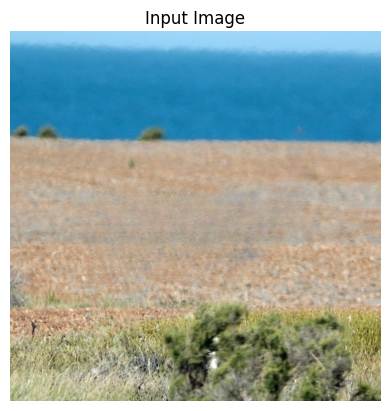

Image Shape  (719, 720, 3)


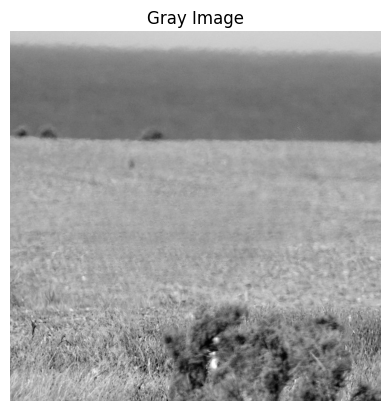

Performing K-means clustering...


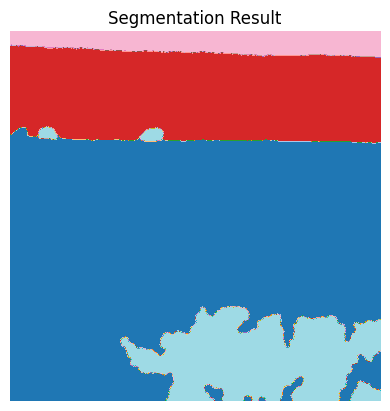

Wavelet Coeffs Shape:  (360, 360, 6)


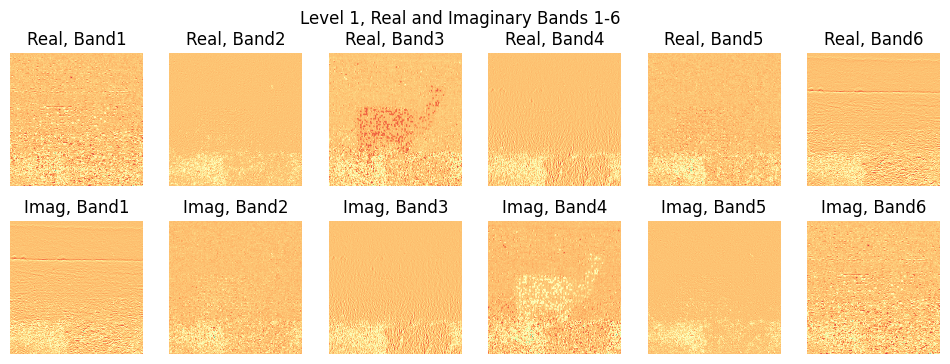

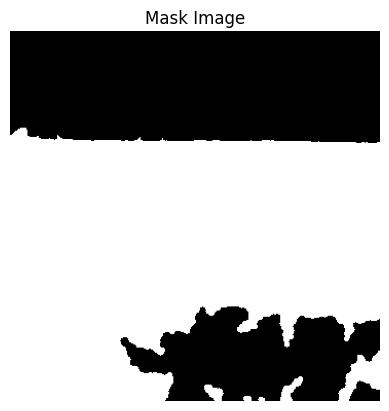

Real Vars:  [0.00150136 0.00306142 0.00228027 0.00152703 0.00115226 0.00078074]
Imag Vars:  [0.00080272 0.00229432 0.00192815 0.00486798 0.0023813  0.00271042]
Real Vars Normalized:  [0.31596557 1.         0.65748968 0.3272228  0.16289884 0.        ]
Imag Vars Normalized:  [0.         0.36691441 0.27684045 1.         0.38830963 0.46926825]
Threshold:  1.0
Picked Bands:
Real 2
Imag 4


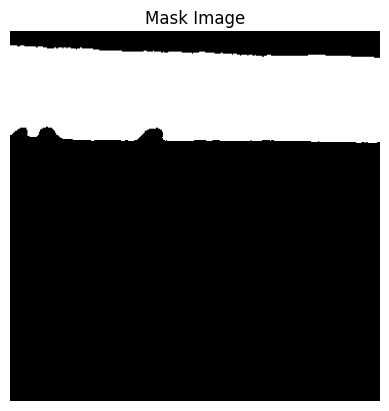

Real Vars:  [9.83017833e-05 1.03397387e-04 2.05925323e-04 8.03402344e-05
 7.18601007e-05 1.96197990e-05]
Imag Vars:  [2.35973881e-05 4.91048134e-05 7.86656504e-05 3.28594618e-05
 7.58560994e-05 1.52252068e-04]
Real Vars Normalized:  [0.42232771 0.4496785  1.         0.3259186  0.28040125 0.        ]
Imag Vars Normalized:  [0.         0.19826271 0.42803155 0.07199174 0.40619363 1.        ]
Threshold:  1.0
Picked Bands:
Real 3
Imag 6


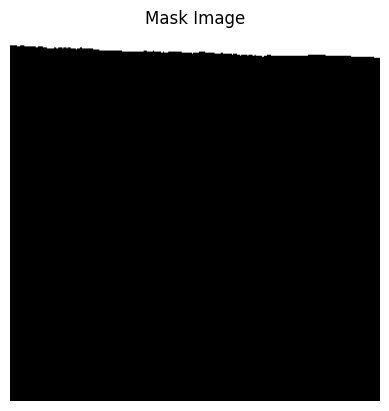

Real Vars:  [1.72961918e-05 2.03772759e-05 4.24557479e-05 1.36892752e-05
 1.31724267e-05 1.92255828e-05]
Imag Vars:  [2.02704431e-05 8.51267255e-06 1.42204990e-05 1.32485569e-06
 1.38931627e-05 2.73234172e-05]
Real Vars Normalized:  [0.140823   0.24603935 1.         0.01764993 0.         0.20671003]
Imag Vars Normalized:  [0.72871676 0.27646979 0.49601372 0.         0.48342317 1.        ]
Threshold:  1.0
Picked Bands:
Real 3
Imag 6


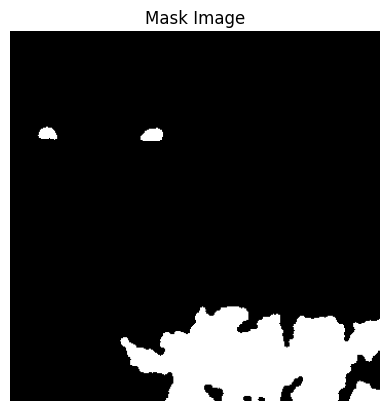

Real Vars:  [0.00048575 0.0001848  0.00076147 0.00083899 0.00022269 0.00012143]
Imag Vars:  [1.75616097e-04 8.46921321e-05 3.62347752e-04 8.01611575e-04
 8.03550316e-05 3.17599955e-04]
Real Vars Normalized:  [0.50772202 0.08830855 0.89196849 1.         0.14111003 0.        ]
Imag Vars Normalized:  [0.13207654 0.00601326 0.39097423 1.         0.         0.32893278]
Threshold:  1.0
Picked Bands:
Real 4
Imag 4
Releavant Bands 4 4


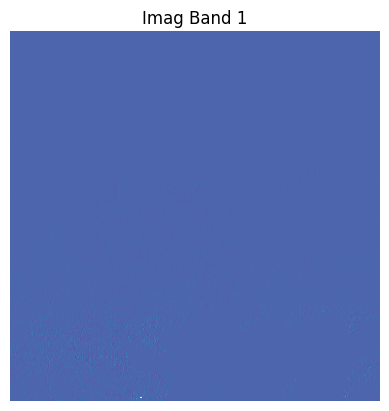

Final Releavant Bands 0 1
No bands available. Adjust threshold maybe.


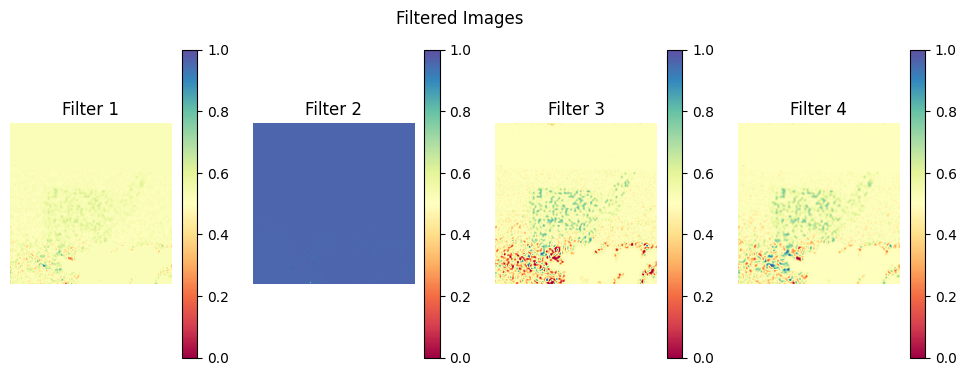

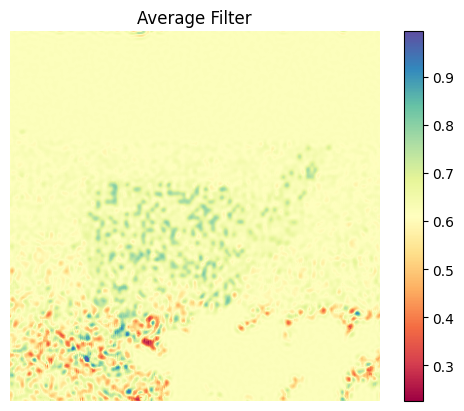

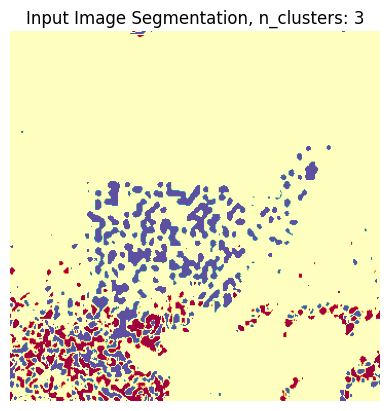

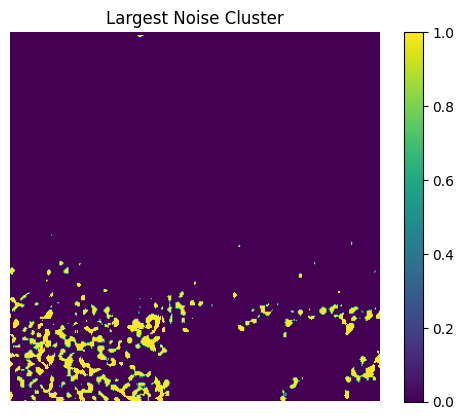

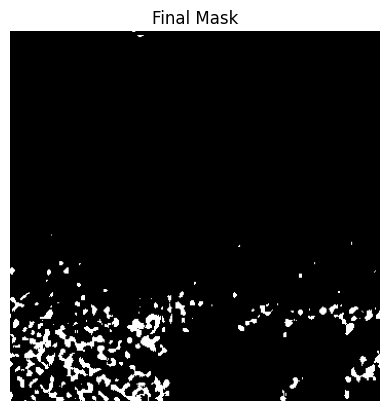

In [27]:
loaded_detections = None
with open("/mntdata/avanti/project/ece251c/data/lama_pkl/0b2a2c061ef16759_altered_filtered.pkl", "rb") as f:
    loaded_detections = pickle.load(f)

final_mask = detect_inpainting(file_path="/mntdata/avanti/project/ece251c/Samsung AI.png", wavelet_type='dtcwt', output_path="../lama", noise_func=noise_zero, loaded_detections=loaded_detections, kernel_size=5, patch_size=64, var_threshold='dynamic', segmentation_method='kmeans', display=True, debug=True)

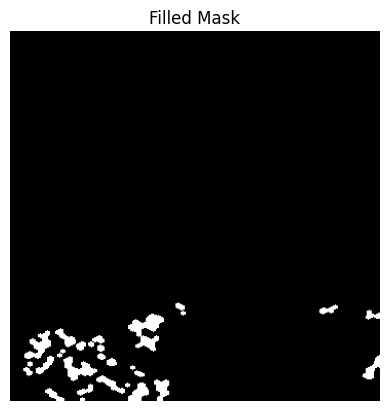

In [28]:
def morph_mask(mask):
    # use cv2 to fill the holes
    mask = mask.astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

    # do opening and closing to remove small noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

    # remove big connected components from the white mask
    mask = morphology.remove_small_objects(mask > 0, min_size=64, connectivity=1).astype(np.uint8)

    # invert the mask and remove small connected components from the black mask and invert it back
    mask = 1 - mask
    mask = morphology.remove_small_objects(mask > 0, min_size=512, connectivity=1).astype(np.uint8)
    mask = 1 - mask

    # open the mask to remove small noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

    return mask


mask = morph_mask(final_mask)
plt.imshow(mask, cmap="gray")
plt.axis('off')
plt.title("Filled Mask")
plt.show()

# Metrics

In [29]:
def calculate_metrics(gt_mask, pred_mask, threshold=0.5):
    # Convert predicted mask to numpy array
    pred_mask = np.array(pred_mask)
    
    # Ensure both masks have the same shape
    if gt_mask.shape != pred_mask.shape:
        raise ValueError("Ground truth and predicted masks must have the same shape.")
    
    # Calculate the total number of pixels
    total_pixels = pred_mask.size

    # Calculate the number of white (1) and black (0) pixels
    num_white = np.sum(pred_mask == 1)
    num_black = np.sum(pred_mask == 0)

    # Calculate the percentage of white pixels
    percent_white = (num_white / total_pixels) * 100
    percent_black = (num_black / total_pixels) * 100

    # Flip the mask if the background is white (more white pixels than black pixels)
    if percent_white > percent_black:
        pred_mask = 1 - pred_mask
    
    # Convert masks to boolean arrays
    gt_mask_bool = gt_mask > threshold
    pred_mask_bool = pred_mask > threshold
    
    # Calculate intersection and union
    intersection = np.logical_and(gt_mask_bool, pred_mask_bool)
    union = np.logical_or(gt_mask_bool, pred_mask_bool)
    
    # Calculate IoU
    union_sum = np.sum(union)
    iou = np.sum(intersection) / union_sum if union_sum > 0 else 1.0
    
    # Calculate accuracy
    accuracy = np.mean(gt_mask_bool == pred_mask_bool)
    
    # Calculate precision and recall
    true_positive = np.sum(intersection)
    false_positive = np.sum(np.logical_and(~gt_mask_bool, pred_mask_bool))
    false_negative = np.sum(np.logical_and(gt_mask_bool, ~pred_mask_bool))
    
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 1.0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 1.0
    
    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {
        "accuracy": accuracy,
        "iou": iou,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
    }

# # get the ground truth mask
# gt_mask = read_img("/mntdata/avanti/project/ece251c/md_0_paper_mask.png")
# print(gt_mask)

# # downsample the ground truth mask to match the predicted mask size
# gt_mask = gt_mask[::2, ::2]
# gt_mask = gt_mask.mean(axis=2)

# print("Ground Truth Mask Shape: ", gt_mask.shape)

# # print the ground truth mask
# plt.imshow(gt_mask, cmap="gray")
# plt.axis('off')
# plt.title("Ground Truth Mask")
# plt.show()

# # calculate the quality metrics
# metrics = calculate_metrics(gt_mask, morphed_mask)
# print(metrics)
# # print(f"Accuracy: {accuracy:.4f}")
# # print(f"IoU: {iou:.4f}")

In [ ]:
# import os

# # Directory containing the files
# directory = "/mntdata/avanti/project/ece251c/data/masks"  # Replace with the path to your "masks" folder

# # Iterate through the files in the directory
# for filename in os.listdir(directory):
#     if "_" in filename:  # Check if the file name contains an underscore
#         new_name = filename.split("_")[0] + os.path.splitext(filename)[1]  # Retain the first part and the file extension
#         old_path = os.path.join(directory, filename)
#         new_path = os.path.join(directory, new_name)
#         os.rename(old_path, new_path)  # Rename the file
#         print(f"Renamed: {filename} -> {new_name}")

# print("Renaming complete!")


Renaming complete!


# Pipeline To Run All Images and Wavelets

In [ ]:
wavelets = ['dtcwt', 'haar', 'sym2', 'db2', 'coif2']
inpainting_methods = ['lama', 'mat']
segmentation_methods = ['kmeans', 'sam']
metrics = [["File Path", "Wavelet", "Inpainting", "Segmentation", "Accuracy", "IOU", "Precision", "Recall", "F1 score"]]

image_dir = "../data/images"
for ip_method in inpainting_methods:
    inpainted_dir = f"../data/inpainted/{ip_method}"                # Change Here
    pickle_dir = f"../data/{ip_method}_pkl"                         # Change Here
    mask_dir = f"../data/masks"                                     # Change Here

    for seg_method in segmentation_methods:
        imgs = os.listdir(image_dir)

        for img_with_extension in imgs:
            img = img_with_extension.split(".")[0]
            inpainted_path = f"{inpainted_dir}/{img}_altered.bmp"       # Change Here      
            mask_path = f"{mask_dir}/{img}.png"                         # Change Here
            pickle_filepath = f"{pickle_dir}/{img}_altered_filtered.pkl"     # Change Here

            loaded_detections = None
            with open(pickle_filepath, "rb") as f:
                loaded_detections = pickle.load(f)

            for wavelet in wavelets:
                output_dir = f"../data/output/{img}"
                output_file_prefix = f"{ip_method}_{seg_method}_{wavelet}"
                os.makedirs(output_dir, exist_ok=True)
                # Get output mask
                output_mask = detect_inpainting(
                    file_path=inpainted_path, 
                    wavelet_type=wavelet, 
                    output_path = f"{output_dir}/{output_file_prefix}",
                    noise_func=noise_zero, 
                    loaded_detections=loaded_detections, 
                    patch_size=64, 
                    var_threshold='dynamic', 
                    kernel_size=5, 
                    segmentation_method=seg_method, 
                    display=False,
                    debug=False)
                
                after_morph_mask = morph_mask(output_mask)

                output_mask_temp = (output_mask > 0.5).astype(np.uint8)
                im = Image.fromarray(output_mask_temp * 255)
                im.save(f"{output_dir}/{output_file_prefix}_pre_morph.png")

                # plt.imshow(output_mask, cmap="gray")
                # plt.colorbar()
                # plt.show()

                im = Image.fromarray(after_morph_mask * 255)
                im.save(f"{output_dir}/{output_file_prefix}_final_mask.png") 

                # Read GT mask
                gt_mask = read_img(mask_path)
                gt_mask = gt_mask[::2, ::2]
                gt_mask = gt_mask.mean(axis=2)

                extra_height = output_mask.shape[0] - gt_mask.shape[0]
                extra_width = output_mask.shape[1] - gt_mask.shape[1]
                output_mask = output_mask[extra_height:, extra_width:]

                # Compute Metrics on it
                computed_metrics = calculate_metrics(gt_mask, output_mask, threshold=0.5)
                computed_metrics = [img, wavelet, ip_method, seg_method] + [value for value in computed_metrics.values()]

                metrics.append(computed_metrics)

result_path = "../result.csv"
with open(result_path, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(metrics)

print(f"Data saved to {result_path}")

In [ ]:
# import os

# def rename_files_in_folder(folder_path):
#     try:
#         # List all files in the folder
#         files = os.listdir(folder_path)
        
#         for file_name in files:
#             # Check if the file follows the naming convention
#             if file_name.endswith('.png') and len(file_name.split('_')) > 1:
#                 # Extract the new name
#                 new_name = file_name.split('_')[0] + '.png'
                
#                 # Define the full paths
#                 old_file_path = os.path.join(folder_path, file_name)
#                 new_file_path = os.path.join(folder_path, new_name)
                
#                 # Rename the file
#                 os.rename(old_file_path, new_file_path)
#                 print(f'Renamed: {file_name} -> {new_name}')
#     except Exception as e:
#         print(f"An error occurred: {e}")

# # Specify the folder path containing the images
# folder_path = "../data/masks"

# # Call the function to rename files
# rename_files_in_folder(folder_path)


# Best Images Only

In [ ]:
good_image_list = [
    "0b2a2c061ef16759.jpg",
    "00f3addd05a6f8e8.jpg",
    "1a70014e04f0422b.jpg",
    "1fca4e8814de1ef8.jpg",
    "2ae7b29752f82465.jpg",
    "3d67b7c7f6a0ca2a.jpg",
    "4bf20ac4061f4be0.jpg",
    "4d211ac255f269a6.jpg",
    "4dbe0d526f7f9bf0.jpg",
    "5a35b6662ee93a7f.jpg",
    "5be7cdc013e0dbb8.jpg",
    "5f0ff10a42ff4380.jpg",
    "7a7ad7084b691cd6.jpg",
    "7da4e355186ce058.jpg",
    "9cea42d857941f46.jpg",
    "55d3576d4da19c99.jpg",
    "77e32d1561fee28b.jpg",
    "85a8c309ae07dab6.jpg",
    "97c4c3df2b76945f.jpg",
    "175ba13d56ecf95a.jpg",
    "265c9966cf3408f6.jpg",
    "694fae862931296e.jpg",
    "02682a455ece74dd.jpg",
    "03052f35d170935d.jpg",
    "5090acd79151e5d2.jpg",
    "6905e899329b6088.jpg",
    "31989a8c33e4efd0.jpg",
    "41805f88c840b506.jpg",
    "44615bece0a97866.jpg",
    "59996cfdbbbeace9.jpg",
    "73265a6c10c3940a.jpg",
    "0974243067d14bde.jpg",
    "1194132584fa4ba2.jpg",
    "a30b783d5a0fa64f.jpg",
    "a72fd6303be85713.jpg",
    "a753ebac051dfd6b.jpg",
    "aadda77be1e8bc0b.jpg",
    "ab495e2ac0be4176.jpg",
    "ae4b5f936328666c.jpg",
    "c4aacd3178b0f9f1.jpg",
    "c33e197e59efc2bc.jpg",
    "c92b7a4d9d48926d.jpg",
    "ea37bb8ce97f36d2.jpg",
    "f0de49cb319b79f6.jpg",
    "f7f53895cf4bf6d1.jpg",
    "f30cedac9b8aed01.jpg",
    "01cc041f0962d41c.jpg",
    "01d831fbda6fa27e.jpg",
    "2a53f4a7f1304cd6.jpg",
    "2b748f85a4fe0eb3.jpg",
    "3b36a27911aa8403.jpg",
    "4a87a57e8401efdf.jpg",
    "9fe3dd8ad92d44f4.jpg",
    "039beb511fd1e7f7.jpg",
    "45a8fd8fbdb5be00.jpg",
    "59e512825446956e.jpg",
    "62d100326bad961a.jpg",
    "74c0ba867859baaf.jpg",
    "215df3e72bb322c4.jpg",
    "318a33e0fe1774a5.jpg",
    "614c97c695a79926.jpg",
    "5506d91a9ac239b7.jpg",
    "7048c5de3ffe1da8.jpg",
    "9154d9c40eabea9a.jpg",
    "44718b76bdbce255.jpg",
    "778082c38b13f711.jpg",
    "69444449be0d216e.jpg",
    "12276881185e2251.jpg",
    "a3ec122655eaa8fb.jpg",
    "a5a9d237b04bc8fb.jpg",
    "a8130a2ce38c9953.jpg",
    "b00b77542f28cb92.jpg",
    "b013ed5aad9c00d7.jpg",
    "b88953006dce138e.jpg",
    "c3955eabb2b204ee.jpg",
    "cab0106def50dd37.jpg",
    "d63ab599cc1846b7.jpg",
    "fc6fd707ddfdecc3.jpg",
    "f63445d1e5247a6d.jpg",
    "fb3fed6d3c8c3276.jpg"
]

# Define thresholds for good metrics
metric_thresholds = {
    "Accuracy": 0.9,    # Example: Accuracy should be at least 80%
    "IOU": 0.8,         # Example: Intersection over Union should be at least 50%
    "F1 score": 0.6     # Example: F1 score should be at least 50%
}

def is_good_metrics(computed_metrics, thresholds):
    metric_names = ["Accuracy", "IOU", "Precision", "Recall", "F1 score"]  # Fixed unique metric names
    metric_indices = {
        "Accuracy": 4,  # Accuracy is at index 4
        "IOU": 5,       # IOU is at index 5
        "F1 score": 8   # F1 score is at index 8
    }
    for metric_name, threshold in thresholds.items():
        index = metric_indices[metric_name]
        if computed_metrics[index] < threshold:  # Compare metric with its threshold
            return False  # Return False if any metric fails the threshold
    return True  # Return True only if all metrics pass

def save_best_result(metrics_row, best_metrics, img, wavelet, ip_method, seg_method, output_dir, output_file_prefix):
    """ Save the best result if required metrics are not achieved and save associated images. """
    if best_metrics is None or any(
        metrics_row[i] > best_metrics[i] for i in range(4, len(metrics_row))
    ):
        # Save images for the new best result
        best_metrics = metrics_row
        for suffix in ["_pre_morph.jpg", "_final_mask.jpg"]:
            src = f"{output_dir}/{output_file_prefix}{suffix}"
            dst = f"{output_dir}/best_{output_file_prefix}{suffix}"
            if os.path.exists(src):
                os.rename(src, dst)
    return best_metrics

def custom_sort_key(filename):
    # Extract the base name without the extension
    base_name = os.path.splitext(filename)[0]
    
    # Check if the filename starts with a number
    if base_name[0].isdigit():
        # Extract numerical and alphabetical parts
        match = re.match(r'(\d+)(.*)', base_name)
        if match:
            # Sort numbers as integers and the rest as strings
            num_part = int(match.group(1))
            alpha_part = match.group(2)
            return (0, num_part, alpha_part.lower())  # Prioritize numbers
    else:
        # If it doesn't start with a number, prioritize later
        return (1, base_name.lower())

wavelets = ['dtcwt', 'haar', 'sym2', 'db2', 'coif2']
inpainting_methods = ['lama', 'mat']
segmentation_methods = ['sam', 'kmeans']
metrics = [["File Path", "Wavelet", "Inpainting", "Segmentation", "Accuracy", "IOU", "Precision", "Recall", "F1 score"]]

result_path = "/mntdata/avanti/project/ece251c/result_good_only.csv"
with open(result_path, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(metrics)

image_dir = "/mntdata/avanti/project/ece251c/data/images"

for ip_method in inpainting_methods:
    inpainted_dir = f"/mntdata/avanti/project/ece251c/data/{ip_method}"
    pickle_dir = f"/mntdata/avanti/project/ece251c/data/{ip_method}_pkl"
    mask_dir = f"/mntdata/avanti/project/ece251c/data/masks"

    for seg_method in segmentation_methods:
        all_imgs = os.listdir(image_dir)
        print(all_imgs)
        imgs = [img for img in all_imgs if any(good_img in img for good_img in good_image_list)]
        imgs.sort(key=custom_sort_key)

        for img_with_extension in imgs:
            img = img_with_extension.split(".")[0]
            print(img)
            inpainted_path = f"{inpainted_dir}/{img}_altered.bmp"
            mask_path = f"{mask_dir}/{img}.png"
            pickle_filepath = f"{pickle_dir}/{img}_altered_filtered.pkl"

            with open(pickle_filepath, "rb") as f:
                loaded_detections = pickle.load(f)

            for wavelet in wavelets:
                output_dir = f"/mntdata/avanti/project/ece251c/data/output_good/{img}"
                output_file_prefix = f"{ip_method}_{seg_method}_{wavelet}"
                os.makedirs(output_dir, exist_ok=True)

                attempts = 0
                max_attempts = 20
                good_metrics_found = False
                best_metrics = None

                while attempts < max_attempts and not good_metrics_found:
                    # Detect inpainting and generate mask
                    output_mask = detect_inpainting(
                        file_path=inpainted_path,
                        wavelet_type=wavelet,
                        output_path=f"{output_dir}/{output_file_prefix}",
                        noise_func=noise_zero,
                        loaded_detections=loaded_detections,
                        patch_size=64,
                        var_threshold='dynamic',
                        kernel_size=5,
                        segmentation_method=seg_method,
                        display=False,
                        debug=False)

                    after_morph_mask = morph_mask(output_mask)

                    output_mask_temp = (output_mask > 0.5).astype(np.uint8)
                    im = Image.fromarray(output_mask_temp * 255)
                    # im.save(f"{output_dir}/{output_file_prefix}_pre_morph.jpg")

                    im = Image.fromarray(after_morph_mask * 255)
                    # im.save(f"{output_dir}/{output_file_prefix}_final_mask.jpg")

                    # Read GT mask
                    gt_mask = read_img(mask_path)
                    gt_mask = gt_mask[::2, ::2]
                    if gt_mask.ndim == 3:  # Color image
                        gt_mask = gt_mask.mean(axis=2)
                    elif gt_mask.ndim == 2:  # Already grayscale
                        pass
                    else:
                        raise ValueError("Unexpected dimensions in gt_mask. Expected 2D or 3D array.")


                    extra_height = output_mask.shape[0] - gt_mask.shape[0]
                    extra_width = output_mask.shape[1] - gt_mask.shape[1]
                    output_mask = output_mask[extra_height:, extra_width:]

                    # Compute metrics
                    computed_metrics = calculate_metrics(gt_mask, output_mask, threshold=0.5)
                    metrics_row = [img, wavelet, ip_method, seg_method] + [value for value in computed_metrics.values()]

                    # Check if the metrics are good
                    good_metrics_found = is_good_metrics(metrics_row, metric_thresholds)

                    # Track the best metrics so far
                    best_metrics = save_best_result(metrics_row, best_metrics, img, wavelet, ip_method, seg_method, output_dir, output_file_prefix)

                    attempts += 1

                # If no good metrics were found, save the best result from the attempts
                if not good_metrics_found and best_metrics is not None:
                    metrics.append(best_metrics)
                
                with open(result_path, "a", newline="") as file:  # Append to the file
                    writer = csv.writer(file)
                    writer.writerows(metrics)
                metrics = []  # Clear the list to avoid duplication

print(f"Filtered data saved to {result_path}")
